<a href="https://colab.research.google.com/github/anuva05/PracticalDeepLearningCourse/blob/master/Lesson3_head_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

Head pose estimation is an important visual cue in many fields, such as human
intention, motivation, attention and so on. In particular, in automotive context, head pose estimation is one of the key elements for attention monitoring and
driver behavior analysis.


This advanced example shows how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. Downloaded the converted dataset (to JPEG) from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In this dataset: The head rotation spans about ±75 degrees for yaw, ±60 degrees for pitch and ±50 degrees for roll. For each frame a depth
image and the corresponding RGB image are provided, acquired sitting in front a
stationary Microsoft Kinect; both of them have a resolution of 640x480. Besides
ground truth pose angles, calibration matrix and head center - the position of
the nose tip - are given.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
#get information about pose
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

Let's look at a sample image from the dataset.

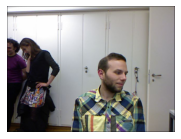

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

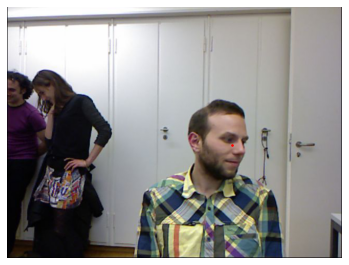

In [11]:
#Plot the coordinates of the center of the face, on the image
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
#Create databunch
#Use sequences 1 to 12 to test the network, since they do not contain data from repeated subjects
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

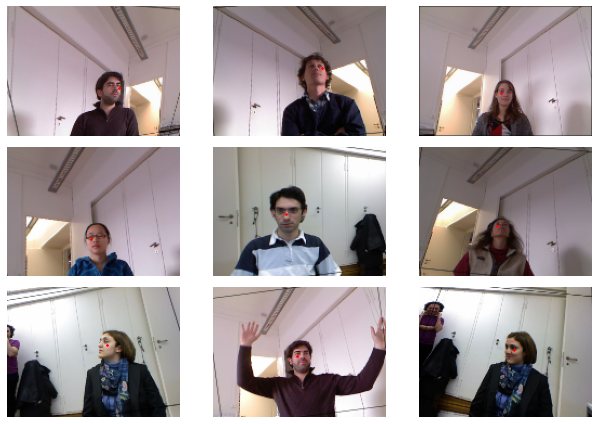

In [13]:
data.show_batch(3, figsize=(9,6))

## Train model

In [14]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Learning rate finder plots l Learning rate vs Loss relationship for a Learner. The idea is to reduce the amount of guesswork on picking a good starting learning rate.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


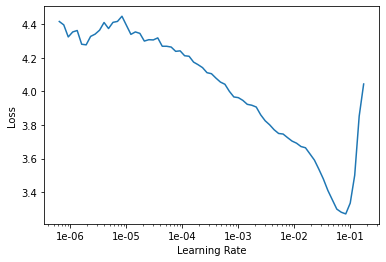

In [15]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.124774,0.048018,03:41
1,0.040691,0.005568,03:43
2,0.015648,0.002173,03:43
3,0.008405,0.001735,03:45
4,0.006539,0.001894,03:47


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

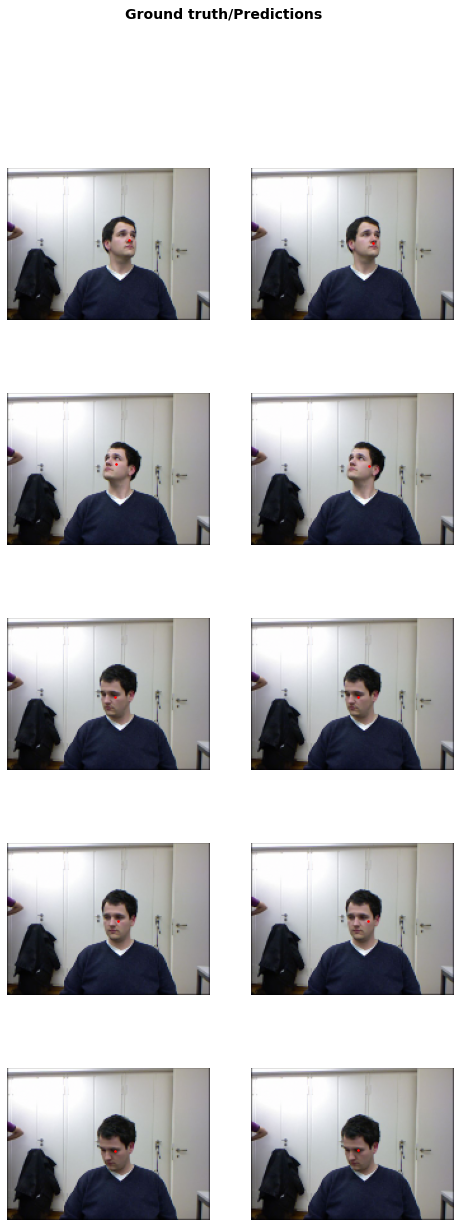

In [20]:
learn.show_results()

## Data augmentation

Augment the data with transformations since training dataset is small.

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

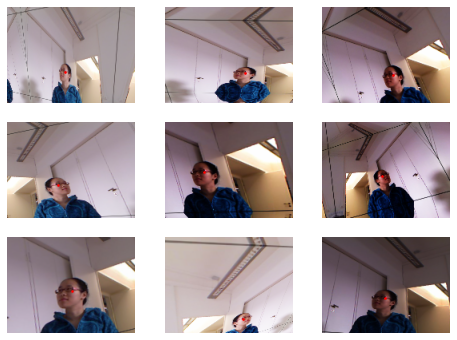

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))